# Desarrollo por Joaquin Zepeda V.

Tarea 5 EL7008 - Clasificación de objetos usando CNNs.

El objetivo de esta tarea es implementar un sistema de clasificación de objetos usando redes neuronales
convolucionales (CNNs). En esta tarea se debe usar la librería pytorch para poder generar los tensores que
corresponden a las imágenes y sus labels (etiquetas), además de implementar arquitecturas de red y códigos
para entrenamiento y evaluación

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-11-15 19:26:16--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.4’

cifar-10-python.tar 100%[===================>] 162.60M  21.7MB/s    in 9.2s    

2022-11-15 19:26:26 (17.7 MB/s) - ‘cifar-10-python.tar.gz.4’ saved [170498071/170498071]



In [ ]:
!tar -xzvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from torchvision import datasets, models, transforms
import time
import os
import random

SEED = 1234


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

device

'cuda'

# Sección 1. Implementar el código para que pytorch acceda a los datasets, para el conjunto de entrenamiento, validación y prueba.

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [ ]:
L = unpickle("/content/cifar-10-batches-py/data_batch_1")

In [ ]:
data,labels,filenames = L['data'],L['labels'],L['filenames']
metadata = unpickle("/content/cifar-10-batches-py/batches.meta")
label_names = metadata['label_names']

In [ ]:
#he first 1024 entries contain the red channel values, the next 1024 the green, 
#and the final 1024 the blue. The image is stored in row-major order, so that the 
#first 32 entries of the array are the red channel values of the first row of the image.
data[0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

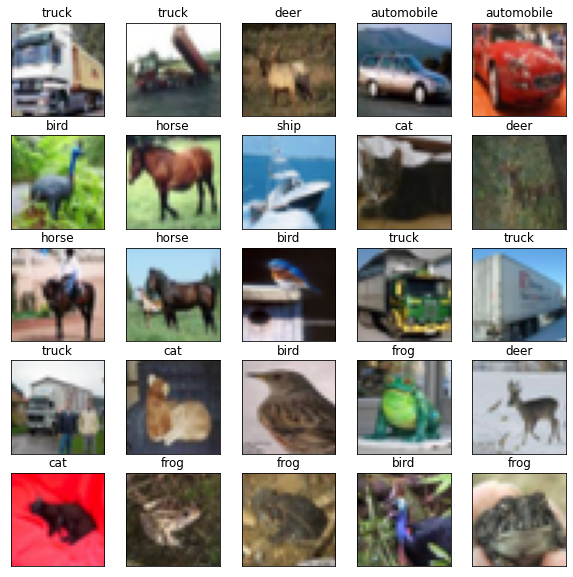

In [ ]:
from google.colab.patches import cv2_imshow


fig=plt.figure(figsize=(10, 10))
for i in range(1, 26):
    fig.add_subplot(5, 5, i)
    img = np.reshape(data[i], (3,32,32)).transpose(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(label_names[labels[i]])
plt.show()

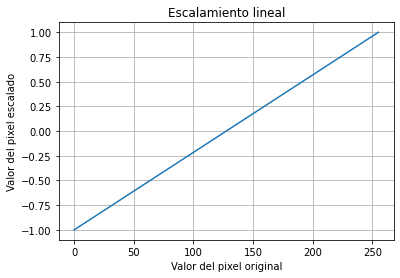

In [ ]:
def escalamiento(x):
    return -1 + 2/255*x

x = np.arange(0,256,1)
plt.title("Escalamiento lineal")
plt.plot(x,escalamiento(x))
plt.xlabel("Valor del pixel original")
plt.ylabel("Valor del pixel escalado")
plt.grid()

In [ ]:
from torch.utils.data import Dataset

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict


class CIFAR10Train(Dataset):
    def __init__(self, path):
        # Constructor, debe leer el archivo data_batch_1 dentro de la carpeta
        # indicada (este archivo se usará para el set de entrenamiento)
        self.dict_data = unpickle(path+'data_batch_1')
        self.labels,self.filenames = self.dict_data['labels'],self.dict_data['filenames']

    def __len__(self):
        # Debe retornar el número de imágenes en el dataset de entrenamiento
        return len(self.filenames)

    def __getitem__(self, index):
        data = self.dict_data['data']
        # Debe retornar un par label, image
        # Donde label es una etiqueta, e image es un arreglo de 3x32x32
        # index es un número (o lista de números) que indica cuáles imágenes
        # y labels se deben retornar
        #escalamineto lineal
        datax = -1 +2/255*data[index]
        img = np.reshape(datax, (3,32,32))
        return self.labels[index], img

class CIFAR10Val(Dataset):
    def __init__(self, path):
        # Constructor, debe leer el archivo data_batch_2 dentro de la carpeta
        # indicada (este archivo se usará para el set de entrenamiento)
        self.dict_data = unpickle(path+'data_batch_2')
        self.labels,self.filenames = self.dict_data['labels'],self.dict_data['filenames']

    def __len__(self):
        # Debe retornar el número de imágenes en el dataset de entrenamiento
        return len(self.filenames)

    def __getitem__(self, index):
        data = self.dict_data['data']
        # Debe retornar un par label, image
        # Donde label es una etiqueta, e image es un arreglo de 3x32x32
        # index es un número (o lista de números) que indica cuáles imágenes
        # y labels se deben retornar
        #escalamineto lineal
        datax = -1 +2/255*data[index]
        img = np.reshape(datax, (3,32,32))
        return self.labels[index], img

class CIFAR10Test(Dataset):
    def __init__(self, path):
        # Constructor, debe leer el archivo test_batch
        # indicada (este archivo se usará para el set de entrenamiento)
        self.dict_data = unpickle(path+'test_batch')
        self.labels,self.filenames = self.dict_data['labels'],self.dict_data['filenames']

    def __len__(self):
        # Debe retornar el número de imágenes en el dataset de entrenamiento
        return len(self.filenames)

    def __getitem__(self, index):
        data = self.dict_data['data']
        # Debe retornar un par label, image
        # Donde label es una etiqueta, e image es un arreglo de 3x32x32
        # index es un número (o lista de números) que indica cuáles imágenes
        # y labels se deben retornar

        #escalamineto lineal
        datax = -1 +2/255*data[index]
        img = np.reshape(datax, (3,32,32))
        return self.labels[index], img

In [ ]:
trainDataset = CIFAR10Train("/content/cifar-10-batches-py/")
valDataset = CIFAR10Val("/content/cifar-10-batches-py/")
testDataset = CIFAR10Test("/content/cifar-10-batches-py/")

In [ ]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader= torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Sección 2. Implementar una red inicial.

 Las primeras capas convolucionales que se recomienda usar están indicadas en el enunciado. Elija un tamaño N de neuronas en la última capa oculta que le parezca
apropiado. Se recomienda usar max pooling cada cierta cantidad de capas para reducir el tamaño
espacial de los tensores. Elija un batch_size inicial que le parezca apropiado.

In [3]:
class MyNet(nn.Module):
 def __init__(self, N=128):
    super(MyNet, self).__init__()
    self.nclasses = 10
    #nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1) #64 filtros de 3x3, 3 canales de entrada
    self.conv2 = nn.Conv2d(64, 64, 3, padding = 1) 
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)

    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)

    self.MaxPool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(8192, 1024)
    self.fc2 = nn.Linear(1024, 24*N)
    self.fc3 = nn.Linear(24*N, N)
    self.fc_last = nn.Linear(N, self.nclasses)
 def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.MaxPool(self.bn2(F.relu(self.conv2(x))))
    x = self.MaxPool(self.bn3(F.relu(self.conv3(x))))

    #transformamos el tensor de una capa convolucional a una capa fully connected
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc_last(x)
    return x


## Sección 2.a Entrenar la red usando el conjunto de entrenamiento y controlando el sobreajuste con el conjunto de validación.


La red puede sufrir sobreajuste si la cantidad de parámetros es grande, a medida que el entrenamiento va
progresando. Para poder evitar el sobreajuste, se recomienda usar un enfoque basado en patience. Además,
se debe ir guardando el menor loss de validación, se debe ir guardando checkpoints cada vez que el loss
actual es menor que el menor loss de validación existente. Posteriormente, para poder evaluar el
desempeño de la red, se debe recuperar el mejor checkpoint almacenado

In [ ]:
# Parte de los prints de los accuracy's y de los loss se basaron en modelos
# del curso Deep learning que estoy cursando actualmente.
def train(net, optimizer, num_epocas):
  inicio = time.time()
  #copiamos el modelo utilizando la libreria copy
  best_model_wts = copy.deepcopy(net.state_dict()) 
  train_losses = []
  train_counter = []
  train_accuracy = []
  val_losses = []
  val_accuracy = []
  best_acc = 0.0
  best_loss = 2e32
  for epoch in range(num_epocas):
    print('Epoch {}/{}'.format(epoch, num_epocas-1))
    print('-' * 10)

    net.train() #Modo entrenamiento

    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(train_loader, 0): # Obtener batch
        labels = data[0].cuda()
        inputs = data[1].cuda().float()
        optimizer.zero_grad()
        outputs = net(inputs) #salidas de la red
        preds = outputs.argmax(axis=1) #predicciones
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_loader.dataset) #promedio de error 
    epoch_acc = running_corrects.double() / len(train_loader.dataset) #promedio de accuracy
    train_losses.append(epoch_loss)
    train_counter.append(epoch)
    train_accuracy.append(epoch_acc)
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    #Validacion 
    net.eval()

    running_loss = 0.0
    running_corrects = 0.0
    for labels,inputs in val_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = net(inputs)
            preds = outputs.argmax(axis=1)
            val_loss = criterion(outputs, labels)
            #val_losses.append(val_loss.item())
            #correct += pred.eq(target.data.view_as(pred)).sum()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    val_losses.append(epoch_loss)
    val_accuracy.append(epoch_acc)
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #chekpoint
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(net.state_dict())
    
    # early stopping, si el error aumenta más de 5 veces respecto al menor error,
    # terminamos el entrenamiento
    if epoch_loss > best_loss*5:
        print('\n'+'-' * 10+'Early Stopping'+'-' * 10+'\n')
        break

  print('Best val loss: {:.4f}'.format(best_loss))
  plt.figure()
  #2b. Graficar las curvas de loss de entrenamiento y validación
  plt.title("Error en cada epoca")
  plt.plot(train_counter, train_losses, label='Entrenamiento',color='blue')
  plt.plot(train_counter,val_losses, label='Validacion',color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  final = time.time()
  print('Training complete in {:.0f}m {:.0f}s'.format((final-inicio)//60, (final-inicio) % 60))

  net.load_state_dict(best_model_wts)
  return net

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,accuracy,N,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(10,7))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title+'\n Accuracy = '+str(round(accuracy,2))+'%'+' N = '+str(N))
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
# calculate accuracy
from sklearn.metrics import  accuracy_score

def evaluar_red(best_net,N,plot=True):
    #Evaluamos la red con los conjuntos de entrenamiento y validación
    best_net.eval()

    y_pred = []
    y_train = []
    for labels,inputs in train_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        y_train += labels.cpu().tolist()
        with torch.no_grad():
            outputs = best_net(inputs)
            preds = outputs.argmax(axis=1)
            y_pred += preds.cpu().tolist()

    accuracy = accuracy_score(y_train, y_pred)*100
    cm = confusion_matrix(y_train, y_pred)
    if plot:
        plot_confusion_matrix(cm, list(range(10)), accuracy,N, title="Matriz de confusión Conjunto Entrenamiento")

    #Val
    best_net.eval()
    y_pred = []
    y_val = []
    for labels,inputs in val_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        y_val += labels.cpu().tolist()
        with torch.no_grad():
            outputs = best_net(inputs)
            preds = outputs.argmax(axis=1)
            y_pred += preds.cpu().tolist()

    accuracy = accuracy_score(y_val, y_pred)*100        
    cm = confusion_matrix(y_val, y_pred)
    if plot:
        plot_confusion_matrix(cm, list(range(10)), accuracy,N, title="Matriz de confusión Conjunto Validación")
    #retornamos el accuracy en el conjunto de validación
    return accuracy

Inicializamos la red.

In [ ]:
N = 256
net = MyNet(N)
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

## Sección 2a y 2b. Entrenar y graficar las curvas de loss de entrenamiento y validación

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7783 Acc: 0.3675
Val Loss: 1.7761 Acc: 0.3164
Epoch 1/14
----------
Train Loss: 1.2718 Acc: 0.5368
Val Loss: 1.5336 Acc: 0.5314
Epoch 2/14
----------
Train Loss: 1.0094 Acc: 0.6352
Val Loss: 1.0813 Acc: 0.5786
Epoch 3/14
----------
Train Loss: 0.7814 Acc: 0.7238
Val Loss: 0.5559 Acc: 0.6103
Epoch 4/14
----------
Train Loss: 0.5046 Acc: 0.8179
Val Loss: 0.7584 Acc: 0.6170
Epoch 5/14
----------
Train Loss: 0.3692 Acc: 0.8712
Val Loss: 0.3783 Acc: 0.6272
Epoch 6/14
----------
Train Loss: 0.2419 Acc: 0.9192
Val Loss: 0.2076 Acc: 0.6344
Epoch 7/14
----------
Train Loss: 0.1299 Acc: 0.9564
Val Loss: 0.0998 Acc: 0.6434
Epoch 8/14
----------
Train Loss: 0.0848 Acc: 0.9723
Val Loss: 0.2003 Acc: 0.6418
Epoch 9/14
----------
Train Loss: 0.0943 Acc: 0.9706
Val Loss: 0.2578 Acc: 0.6353
Epoch 10/14
----------
Train Loss: 0.1437 Acc: 0.9566
Val Loss: 0.4339 Acc: 0.6291
Epoch 11/14
----------
Train Loss: 0.1054 Acc: 0.9665
Val Loss: 0.0882 Acc: 0.6434
Epoch 12/14
----------
Train Loss: 0

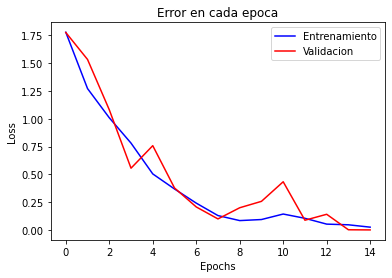

Training complete in 0m 53s


In [ ]:
best_net_1 = train(net, optimizer, num_epocas=15)

# Sección 2.c Evaluar la red sobre los conjuntos de entrenamiento y validación, usando el mejor checkpoint almacenado

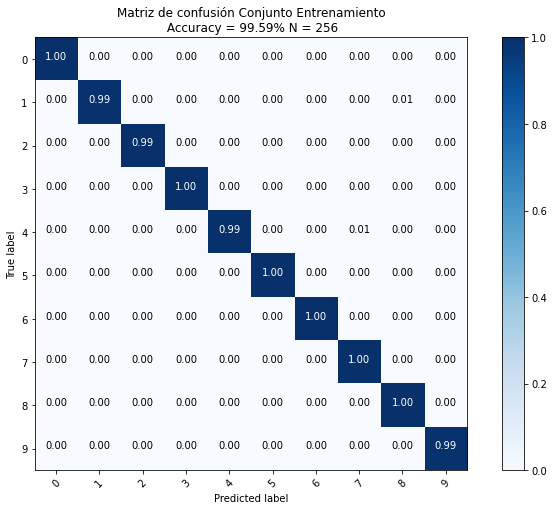

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


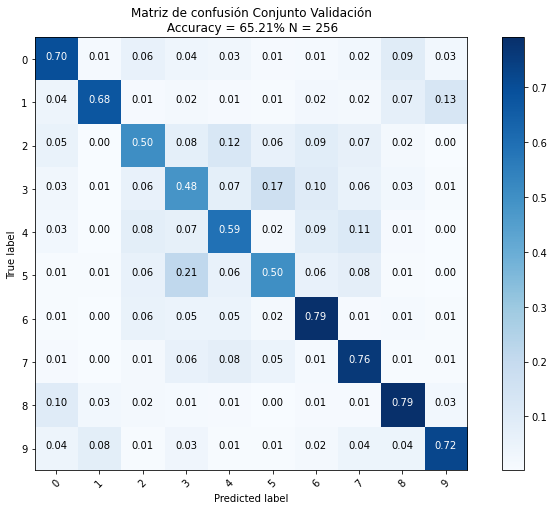

65.21000000000001

In [ ]:
evaluar_red(best_net_1,N=256)

# Sección 3. Modificar el valor de N, repitiendo el Paso 2 hasta obtener una red con un buen desempeño.

Se prueban distintos valores de N, buscando obtener una red con mejor desempeño. Se selecciona el N que arroja mayor accuracy en el conjunto de validación.


Model con N=16
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 2.0200 Acc: 0.2549
Val Loss: 2.0506 Acc: 0.2977
Epoch 1/19
----------
Train Loss: 1.6005 Acc: 0.4318
Val Loss: 1.1605 Acc: 0.4777
Epoch 2/19
----------
Train Loss: 1.2215 Acc: 0.5679
Val Loss: 1.2716 Acc: 0.5616
Epoch 3/19
----------
Train Loss: 0.9419 Acc: 0.6697
Val Loss: 1.2928 Acc: 0.6139
Epoch 4/19
----------
Train Loss: 0.7276 Acc: 0.7501
Val Loss: 1.0533 Acc: 0.6215
Epoch 5/19
----------
Train Loss: 0.5278 Acc: 0.8176
Val Loss: 0.3708 Acc: 0.6209
Epoch 6/19
----------
Train Loss: 0.2758 Acc: 0.9063
Val Loss: 0.4373 Acc: 0.6437
Epoch 7/19
----------
Train Loss: 0.1774 Acc: 0.9449
Val Loss: 0.3780 Acc: 0.6463
Epoch 8/19
----------
Train Loss: 0.0978 Acc: 0.9705
Val Loss: 0.0852 Acc: 0.6493
Epoch 9/19
----------
Train Loss: 0.0552 Acc: 0.9843
Val Loss: 0.0296 Acc: 0.6549
Epoch 10/19
----------
Train Loss: 0.0263 Acc: 0.9940
Val Loss: 0.0056 Acc: 0.6547
Epoch 11/19
----------
Train Loss: 0.0148 Acc: 0.9962
Val Loss: 0.0834 Acc: 0.6506

----------Early Stopping----------


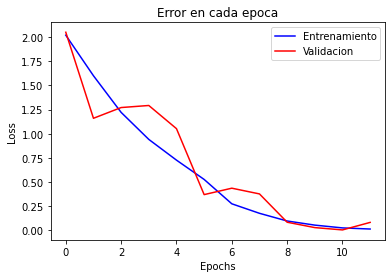

Training complete in 0m 39s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=32
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7200 Acc: 0.3704
Val Loss: 1.2532 Acc: 0.3818
Epoch 1/19
----------
Train Loss: 1.2145 Acc: 0.5601
Val Loss: 1.0180 Acc: 0.5457
Epoch 2/19
----------
Train Loss: 0.9258 Acc: 0.6659
Val Loss: 1.0006 Acc: 0.6004
Epoch 3/19
----------
Train Loss: 0.6692 Acc: 0.7578
Val Loss: 0.5255 Acc: 0.6490
Epoch 4/19
----------
Train Loss: 0.3970 Acc: 0.8590
Val Loss: 0.5205 Acc: 0.6419
Epoch 5/19
----------
Train Loss: 0.2437 Acc: 0.9147
Val Loss: 0.2774 Acc: 0.6527
Epoch 6/19
----------
Train Loss: 0.1446 Acc: 0.9547
Val Loss: 0.0383 Acc: 0.6513
Epoch 7/19
----------
Train Loss: 0.0647 Acc: 0.9794
Val Loss: 0.0467 Acc: 0.6708
Epoch 8/19
----------
Train Loss: 0.0357 Acc: 0.9904
Val Loss: 0.0027 Acc: 0.6584
Epoch 9/19
----------
Train Loss: 0.0130 Acc: 0.9971
Val Loss: 0.0049 Acc: 0.6754
Epoch 10/19
----------
Train Loss: 0.0039 Acc: 0.9991
Val Loss: 0.0361 Acc: 0.6774

----------Early Stopping----------

Best val loss: 0.0027


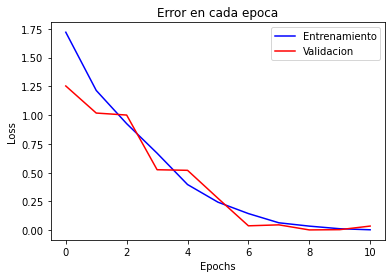

Training complete in 0m 37s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=64
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.6742 Acc: 0.3953
Val Loss: 1.4239 Acc: 0.3893
Epoch 1/19
----------
Train Loss: 1.2512 Acc: 0.5470
Val Loss: 1.5323 Acc: 0.5688
Epoch 2/19
----------
Train Loss: 0.9745 Acc: 0.6521
Val Loss: 1.0369 Acc: 0.5999
Epoch 3/19
----------
Train Loss: 0.6986 Acc: 0.7550
Val Loss: 0.4795 Acc: 0.6362
Epoch 4/19
----------
Train Loss: 0.4211 Acc: 0.8517
Val Loss: 0.7039 Acc: 0.6285
Epoch 5/19
----------
Train Loss: 0.3070 Acc: 0.8976
Val Loss: 0.3156 Acc: 0.6511
Epoch 6/19
----------
Train Loss: 0.1336 Acc: 0.9555
Val Loss: 0.4107 Acc: 0.6427
Epoch 7/19
----------
Train Loss: 0.0986 Acc: 0.9653
Val Loss: 0.1754 Acc: 0.6480
Epoch 8/19
----------
Train Loss: 0.0749 Acc: 0.9763
Val Loss: 0.0282 Acc: 0.6659
Epoch 9/19
----------
Train Loss: 0.0429 Acc: 0.9856
Val Loss: 0.0241 Acc: 0.6586
Epoch 10/19
----------
Train Loss: 0.0253 Acc: 0.9919
Val Loss: 0.0315 Acc: 0.6616
Epoch 11/19
----------
Train Loss: 0.0196 Acc: 0.9936
Val Loss: 0.0734 Acc: 0.6600
Epoch 12/19
----------
Train Loss: 0

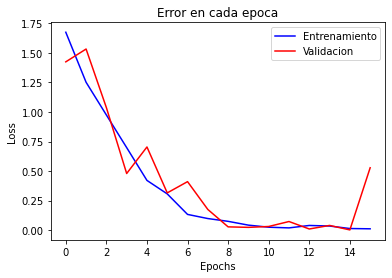

Training complete in 0m 53s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=128
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.6889 Acc: 0.3787
Val Loss: 1.7089 Acc: 0.4004
Epoch 1/19
----------
Train Loss: 1.2586 Acc: 0.5407
Val Loss: 1.1372 Acc: 0.5484
Epoch 2/19
----------
Train Loss: 0.9752 Acc: 0.6496
Val Loss: 0.7143 Acc: 0.5822
Epoch 3/19
----------
Train Loss: 0.6976 Acc: 0.7486
Val Loss: 0.5417 Acc: 0.6115
Epoch 4/19
----------
Train Loss: 0.4633 Acc: 0.8362
Val Loss: 0.5743 Acc: 0.6054
Epoch 5/19
----------
Train Loss: 0.3149 Acc: 0.8928
Val Loss: 0.7880 Acc: 0.5930
Epoch 6/19
----------
Train Loss: 0.2428 Acc: 0.9185
Val Loss: 0.1471 Acc: 0.6405
Epoch 7/19
----------
Train Loss: 0.1249 Acc: 0.9592
Val Loss: 0.0307 Acc: 0.6387
Epoch 8/19
----------
Train Loss: 0.0479 Acc: 0.9850
Val Loss: 0.0757 Acc: 0.6478
Epoch 9/19
----------
Train Loss: 0.0480 Acc: 0.9849
Val Loss: 0.0071 Acc: 0.6478
Epoch 10/19
----------
Train Loss: 0.0192 Acc: 0.9940
Val Loss: 0.0008 Acc: 0.6449
Epoch 11/19
----------
Train Loss: 0.0251 Acc: 0.9924
Val Loss: 0.0009 Acc: 0.6468
Epoch 12/19
----------
Train Loss: 0

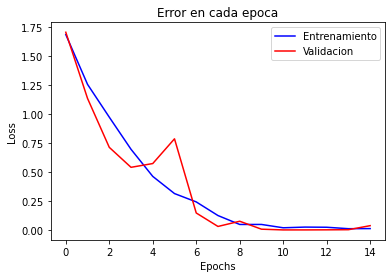

Training complete in 0m 51s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=256
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.9982 Acc: 0.3081
Val Loss: 1.6114 Acc: 0.3830
Epoch 1/19
----------
Train Loss: 1.4004 Acc: 0.4830
Val Loss: 1.1748 Acc: 0.4943
Epoch 2/19
----------
Train Loss: 1.1347 Acc: 0.5815
Val Loss: 0.7465 Acc: 0.5607
Epoch 3/19
----------
Train Loss: 0.8864 Acc: 0.6788
Val Loss: 0.5882 Acc: 0.5732
Epoch 4/19
----------
Train Loss: 0.6466 Acc: 0.7672
Val Loss: 1.1948 Acc: 0.5852
Epoch 5/19
----------
Train Loss: 0.4639 Acc: 0.8356
Val Loss: 0.6101 Acc: 0.6006
Epoch 6/19
----------
Train Loss: 0.3261 Acc: 0.8840
Val Loss: 0.4644 Acc: 0.6187
Epoch 7/19
----------
Train Loss: 0.2096 Acc: 0.9321
Val Loss: 0.3207 Acc: 0.6172
Epoch 8/19
----------
Train Loss: 0.1549 Acc: 0.9465
Val Loss: 0.0406 Acc: 0.6223
Epoch 9/19
----------
Train Loss: 0.0619 Acc: 0.9798
Val Loss: 0.0348 Acc: 0.6113
Epoch 10/19
----------
Train Loss: 0.0611 Acc: 0.9800
Val Loss: 0.0204 Acc: 0.6291
Epoch 11/19
----------
Train Loss: 0.0374 Acc: 0.9886
Val Loss: 0.0051 Acc: 0.6268
Epoch 12/19
----------
Train Loss: 0

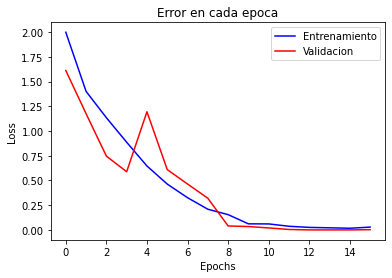

Training complete in 0m 56s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
models = []
accuracys = []
n_list = [16,32,64,128,256]
for N in n_list:
    print(f'\nModel con N={N}')
    net = MyNet(N)
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 
    best_net = train(net, optimizer, num_epocas=20)
    models.append(best_net)
    accuracys.append(evaluar_red(best_net,N,plot=False))

## Resultados

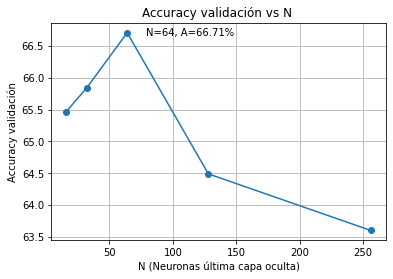

In [ ]:
plt.plot(n_list,accuracys,'o-')
plt.title('Accuracy validación vs N ')
plt.ylabel('Accuracy validación')
plt.xlabel('N (Neuronas última capa oculta)')
plt.grid()
# Texto en la gráfica en coordenadas (x,y)
idx = np.argmax(accuracys)

texto1 = plt.text( n_list[idx]+15,accuracys[idx]-0.05, f'N={n_list[idx]}, A='+str(round(accuracys[idx],2))+'%', fontsize=10)

N = n_list[idx]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


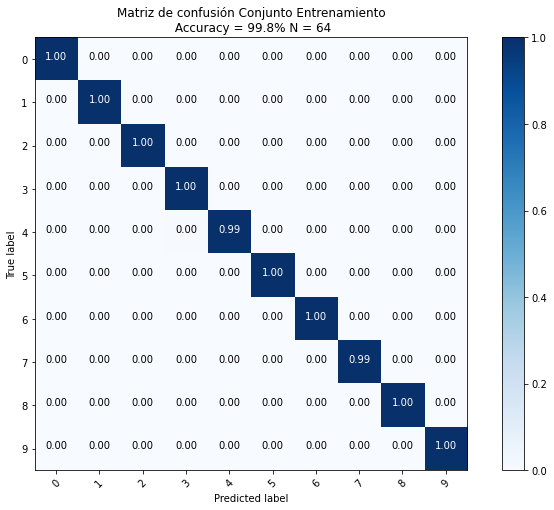

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


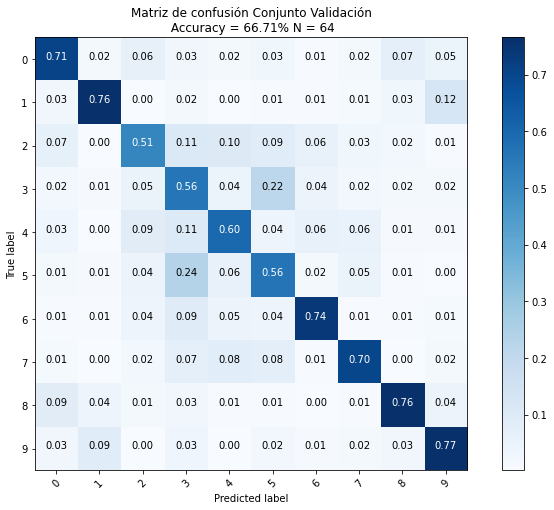

66.71000000000001

In [ ]:
#evaluamos el desempeño con el modelo que entrega mejor accuracy de validación
evaluar_red(models[idx],n_list[idx])

# Sección 4. Repetir el Paso 2 usando dos números distintos de capas convolucionales y elija el que genere los mejores resultados

In [ ]:
# agregando una capa convolucional más
class MyNet2(nn.Module):
 def __init__(self, N=128):
    super(MyNet2, self).__init__()
    self.nclasses = 10
    #nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1) #64 filtros de 3x3, 3 canales de entrada
    self.conv2 = nn.Conv2d(64, 64, 3, padding = 1) 
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)

    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)
    self.bn4 = torch.nn.BatchNorm2d(256)

    self.MaxPool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 24*N)
    self.fc3 = nn.Linear(24*N, N)
    self.fc_last = nn.Linear(N, self.nclasses)
 def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.MaxPool(self.bn2(F.relu(self.conv2(x))))
    x = self.MaxPool(self.bn3(F.relu(self.conv3(x))))
    x = self.MaxPool(self.bn4(F.relu(self.conv4(x))))

    #transformamos el tensor de una capa convolucional a una capa fully connected
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc_last(x)
    return x


Model con N=64
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7147 Acc: 0.3684
Val Loss: 1.4252 Acc: 0.3736
Epoch 1/19
----------
Train Loss: 1.3149 Acc: 0.5275
Val Loss: 0.9938 Acc: 0.5138
Epoch 2/19
----------
Train Loss: 1.0584 Acc: 0.6190
Val Loss: 0.7872 Acc: 0.5835
Epoch 3/19
----------
Train Loss: 0.8349 Acc: 0.7011
Val Loss: 1.1713 Acc: 0.6374
Epoch 4/19
----------
Train Loss: 0.6148 Acc: 0.7822
Val Loss: 0.7478 Acc: 0.6713
Epoch 5/19
----------
Train Loss: 0.4025 Acc: 0.8602
Val Loss: 0.2533 Acc: 0.6649
Epoch 6/19
----------
Train Loss: 0.2256 Acc: 0.9210
Val Loss: 0.7823 Acc: 0.6693
Epoch 7/19
----------
Train Loss: 0.2414 Acc: 0.9208
Val Loss: 0.0739 Acc: 0.6629
Epoch 8/19
----------
Train Loss: 0.1009 Acc: 0.9655
Val Loss: 0.1508 Acc: 0.6686
Epoch 9/19
----------
Train Loss: 0.1190 Acc: 0.9610
Val Loss: 0.0122 Acc: 0.6709
Epoch 10/19
----------
Train Loss: 0.0554 Acc: 0.9822
Val Loss: 0.0078 Acc: 0.6933
Epoch 11/19
----------
Train Loss: 0.0358 Acc: 0.9899
Val Loss: 0.0418 Acc: 0.6922

----------Early Stopping----------


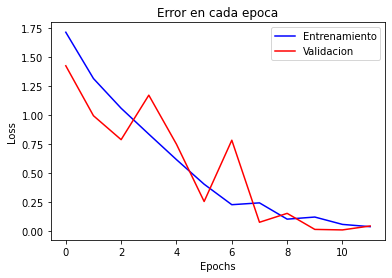

Training complete in 0m 43s


In [ ]:

print(f'\nModel con N={N}')
net3 = MyNet2(N)
net3.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=1e-3) 
best_net3 = train(net3, optimizer, num_epocas=20)


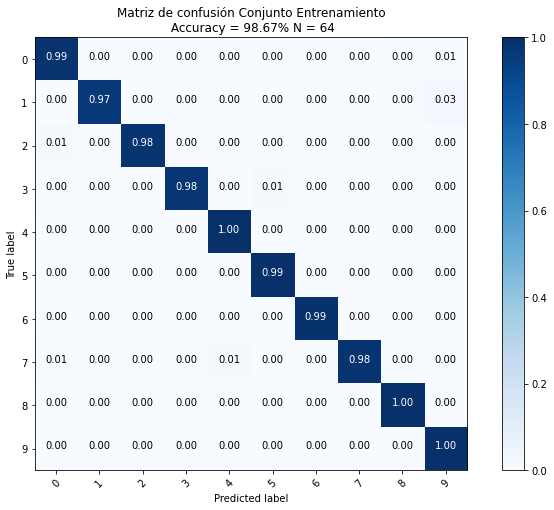

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


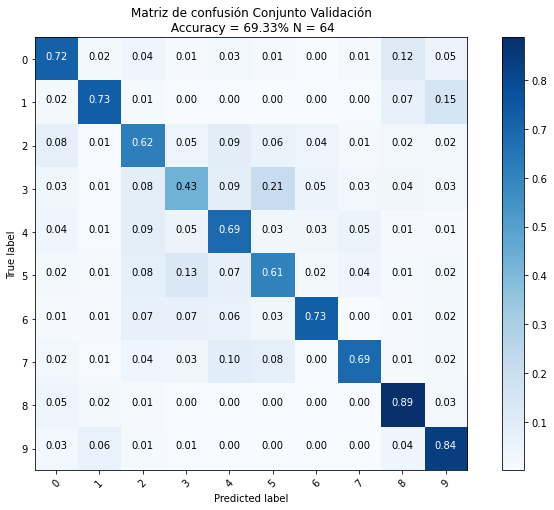

69.33

In [ ]:
evaluar_red(best_net3,N)

In [ ]:
#agregando 2 capas convolucionales más
class MyNet3(nn.Module):
 def __init__(self, N=16):
    super(MyNet3, self).__init__()
    self.nclasses = 10
    #nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1) #64 filtros de 3x3, 3 canales de entrada
    self.conv2 = nn.Conv2d(64, 64, 3, padding = 1) 
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv5 = nn.Conv2d(256, 512, 3, padding = 1)

    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)
    self.bn4 = torch.nn.BatchNorm2d(256)
    self.bn5 = torch.nn.BatchNorm2d(512)

    self.MaxPool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(8192, 1024)
    self.fc2 = nn.Linear(1024, 24*N)
    self.fc3 = nn.Linear(24*N, N)
    self.fc_last = nn.Linear(N, self.nclasses)
 def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.MaxPool(self.bn2(F.relu(self.conv2(x))))
    x = self.MaxPool(self.bn3(F.relu(self.conv3(x))))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.MaxPool(self.bn5(F.relu(self.conv5(x))))

    #transformamos el tensor de una capa convolucional a una capa fully connected
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc_last(x)
    return x


Model con N=64
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7841 Acc: 0.3360
Val Loss: 1.9107 Acc: 0.3269
Epoch 1/19
----------
Train Loss: 1.4163 Acc: 0.4780
Val Loss: 1.2247 Acc: 0.4620
Epoch 2/19
----------
Train Loss: 1.2491 Acc: 0.5411
Val Loss: 1.2203 Acc: 0.5549
Epoch 3/19
----------
Train Loss: 1.0300 Acc: 0.6283
Val Loss: 0.6881 Acc: 0.5527
Epoch 4/19
----------
Train Loss: 0.8706 Acc: 0.6828
Val Loss: 0.8483 Acc: 0.6110
Epoch 5/19
----------
Train Loss: 0.7483 Acc: 0.7323
Val Loss: 0.5128 Acc: 0.6152
Epoch 6/19
----------
Train Loss: 0.6372 Acc: 0.7754
Val Loss: 0.8864 Acc: 0.6769
Epoch 7/19
----------
Train Loss: 0.4411 Acc: 0.8459
Val Loss: 0.5544 Acc: 0.6764
Epoch 8/19
----------
Train Loss: 0.3083 Acc: 0.8864
Val Loss: 0.6358 Acc: 0.6686
Epoch 9/19
----------
Train Loss: 0.2922 Acc: 0.9007
Val Loss: 0.4755 Acc: 0.6831
Epoch 10/19
----------
Train Loss: 0.2249 Acc: 0.9233
Val Loss: 0.1181 Acc: 0.6998
Epoch 11/19
----------
Train Loss: 0.0994 Acc: 0.9676
Val Loss: 0.0632 Acc: 0.7057
Epoch 12/19
----------
Train Loss: 0

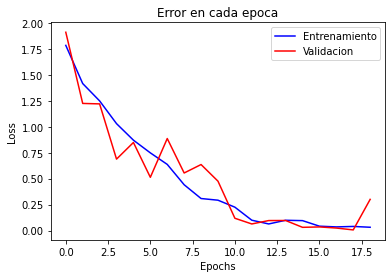

Training complete in 1m 42s


In [ ]:

print(f'\nModel con N={N}')
net4 = MyNet3(N)
net4.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net4.parameters(), lr=1e-3) 
best_net4 = train(net4, optimizer, num_epocas=20)


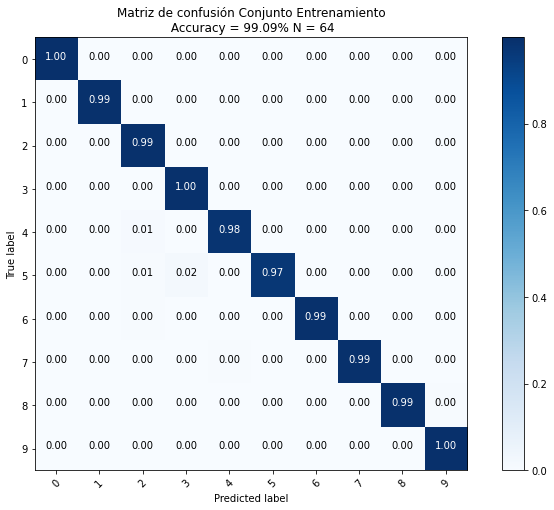

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


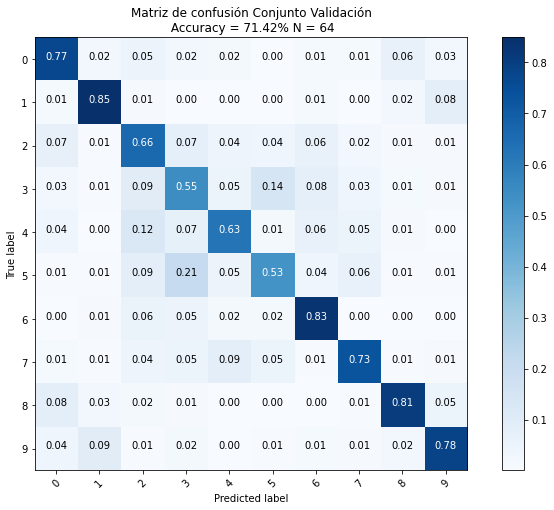

71.41999999999999

In [ ]:
evaluar_red(best_net4,N)

# Sección 5. Usando la mejor configuración obtenida en los pasos anteriores, evaluar la mejor red sobre el conjunto de prueba.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


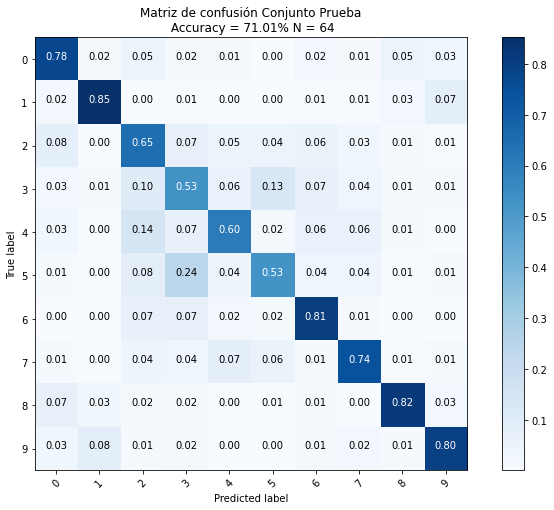

In [ ]:
# calculate accuracy
from sklearn.metrics import  accuracy_score

#Evaluamos la red con los conjuntos de prueba
best_net4.eval()
y_pred = []
y_test = []
for labels,inputs in test_loader:
    inputs = inputs.to(device).float()
    labels = labels.to(device)
    y_test += labels.cpu().tolist()
    with torch.no_grad():
        outputs = best_net4(inputs)
        preds = outputs.argmax(axis=1)
        y_pred += preds.cpu().tolist()

accuracy = accuracy_score(y_test, y_pred)*100        
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(10)), accuracy,N, title="Matriz de confusión Conjunto Prueba")
